# Calibration

The aim is to find the slope between sensor readout (μS/cm) and concentration (g/l) for each sensor

In [1]:
bucketsize = 1.0 # calibration bucket size in liters
solution_conc = 1.0 # calibration solution concentration (g/l)

1.0

Total calibration ml solution vs sensor readout (μS/cm) for each sensor
Example from 2021:

In [2]:
calibrations = Dict(309=>[ ## sensor 309, not used
                             # first calibration
                          [ 0 0.54 ## First row needs to be the background reading!
                            1 1.35
                            5 4.7
                            10 9.7],
                             # second calibration
                          [ 0 1.6
                            1 2.43
                            2 3.34
                            5 6.23
                            10 12.3
                            20 28.6 ],
                            # etc.
                          ],
                    145=>[## sensor 145
                            [ 0 0.41 ## First row needs to be the background reading! First calib with 10g/L -> actual volumes times 10
                              10 10.78
                              30 38.9
                              70 85.65 ],
                                #second calib with 1g/L -> actual volumes
                            [ 0 0.32
                              5 5.04
                              10 11.22 ],
                            ],
                    :wtw=>[ ## note that sensors non-numeric ID are best written as a :symbol
                           [0 2.3
                            10 23.9
                            30 68.7
                            70 155.2],
                                #second calib, added by myself
                            [ 0 1.5
                              5 13.7
                              10 24.6],
                            ],
                    # add more:
                    # 049=>[],
                    # :someother=>[], ## etc
                    )

Dict{Any, Vector{Matrix{Float64}}} with 3 entries:
  145  => [[0.0 0.41; 10.0 10.78; 30.0 38.9; 70.0 85.65], [0.0 0.32; 5.0 5.04; …
  309  => [[0.0 0.54; 1.0 1.35; 5.0 4.7; 10.0 9.7], [0.0 1.6; 1.0 2.43; … ; 10.…
  :wtw => [[0.0 2.3; 10.0 23.9; 30.0 68.7; 70.0 155.2], [0.0 1.5; 5.0 13.7; 10.…

Convert ml solution added to concentration

In [3]:
"""
Converts ml added to bucket to a concentration (g/l == kg/m^3).

Input:

- ml -- how many mililiters were added
- solution_conc -- the concentration of the calibration solution (kg/m^3 == g/l)
- bucketsize -- the size of the bucket/bottle to which the solution was added (l)

Output:

- concentration (kg/m^3 == g/l)
"""
function ml_to_concentration(ml, solution_conc, bucketsize)
    mass = ml/1e3 * solution_conc # salt mass added to bucket (g)
    return mass/bucketsize # concentration in g/l (== kg/m^3)
end

ml_to_concentration

An example, convert to concentration (g/l):

In [4]:
ml_to_concentration(calibrations[145][1][:,1], solution_conc, bucketsize)

4-element Vector{Float64}:
 0.0
 0.01
 0.03
 0.07

Now fit a linear function to it.  The function is pre-defined in the file helper_functions.jl with
name `fit_calibration`.

In [5]:
using NBInclude
@nbinclude("helper_functions.ipynb")

delta_cond2conc = Dict(a[1] => fit_calibration(bucketsize, solution_conc, a[2]...) for a in pairs(calibrations))

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000818±2.8e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000812±9.9e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000456±5.18e-6



Dict{Any, var"#1#3"{LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}, var"#fn#2"}} with 3 entries:
  145  => #1
  309  => #1
  :wtw => #1

Plot them

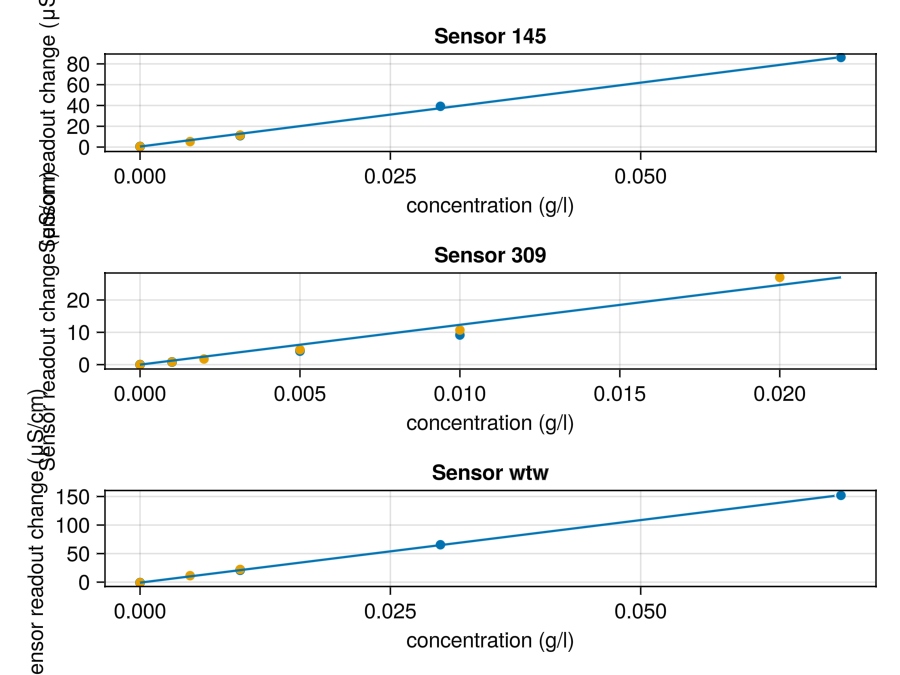

In [6]:
using GLMakie
Makie.inline!(true)
# Note if you want a zoom-able plot opening in a new window do:
# Makie.inline!(false)
# to go back to in-line plots set it true again

fig = Figure()
for (i,sens) in enumerate(keys(delta_cond2conc))
    Axis(fig[i, 1], title="Sensor $sens",
        xlabel="concentration (g/l)",
        ylabel="Sensor readout change (μS/cm)")
    delta_fn = delta_cond2conc[sens]
    calis = calibrations[sens]
    # scatter plots (x,y) points
    maxreadout = 0
    for cali in calis
        conc = ml_to_concentration(cali[:,1], solution_conc, bucketsize)
        maxreadout = max(maxreadout, maximum(cali[:,2].-cali[1,2]))
        scatter!(conc, cali[:,2].-cali[1,2],
                 label="Calibration 1")
    end

    # Now plot the line of best fit:
    readouts = 0:maxreadout
    # (lines! plots a line)
    lines!(delta_fn(readouts), readouts, label="line of best fit")
end
fig

Save them as files:

In [7]:
# mkpath("../plots")
# save("../plots/calibration.png", fig) ## to save this figure to a file, useful for your presentation

## Stage-Discharge Relation
Discharge where measured with salt dilution vs. pressure head (stage) at that time

## Calibration of pressure sensors against air pressure (called sd, output from channel 2 from 554)

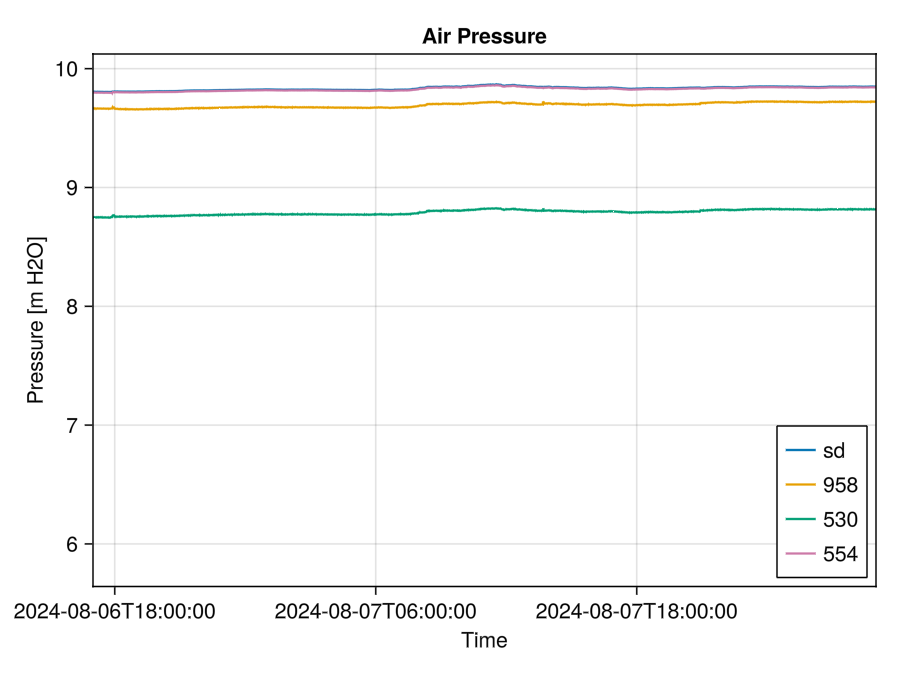

In [8]:
#compare pressure sensors for air pressure by comparing the values when all sensors measured the air pressure 
# -> calibration necessary, using constant offset

using Dates
d_sd = read_Keller("../data/raw/2024_Konki_Pressure/Stage_17_09_2023-23_14_00-206554.CSV", presshead="P2", temphead="TOB2") #reads the air pressure channel from 554 (P2)
d_958 = read_Keller("../data/raw/2024_Konki_Pressure/_05_09_2023-13_32_35-99958.CSV") #only one pressure channel
d_530 = read_Keller("../data/raw/2024_Konki_Pressure/Druck Keller DCX-22 1_05_09_2023-13_19_16-62530.CSV") #only one pressure channel
d_554 = read_Keller("../data/raw/2024_Konki_Pressure/Stage_17_09_2023-23_14_00-206554.CSV") #water pressure channel from 554
fig = Figure()
ax = Axis(fig[1,1], title = "Air Pressure", xlabel = "Time", ylabel = "Pressure [m H2O]")
lines!(ax, d_sd[:t], d_sd[:press], label = "sd")
lines!(ax, d_958[:t], d_958[:press], label = "958")
lines!(ax, d_530[:t], d_530[:press], label = "530")
lines!(ax, d_554[:t], d_554[:press], label = "554")

xmin = DateTime(2024, 8, 6, 17, 00, 0)
xmax = DateTime(2024, 8, 8, 5, 00, 0)
xlims!(ax, xmin, xmax)

axislegend(ax, position = :rb)
fig

In [9]:
#calibrate other pressure sensors against sd using a constan offset

using Statistics
# Filter data by the desired time period and take the mean
mean_d_958 = mean([d_958[:press][i] for i in 1:length(d_958[:t]) if d_958[:t][i] >= xmin && d_958[:t][i] <= xmax])
# same for d_sd
mean_d_sd = mean([d_sd[:press][i] for i in 1:length(d_sd[:t]) if d_sd[:t][i] >= xmin && d_sd[:t][i] <= xmax])
# same for d_530
mean_d_530 = mean([d_530[:press][i] for i in 1:length(d_530[:t]) if d_530[:t][i] >= xmin && d_530[:t][i] <= xmax])
# same for d_554
mean_d_554 = mean([d_554[:press][i] for i in 1:length(d_554[:t]) if d_554[:t][i] >= xmin && d_554[:t][i] <= xmax])

delta_calib_958 = mean_d_sd - mean_d_958
delta_calib_530 = mean_d_sd - mean_d_530
delta_calib_554 = mean_d_sd - mean_d_554



print("958: ", mean_d_958," sd: ", mean_d_sd, " 530: ", mean_d_530)
print(" delta_calib_958: ", delta_calib_958, " delta_delta_calib_530: ", delta_calib_530, " delta_calib_554: ", delta_calib_554)

958: 9.700806565484955 sd: 9.842223520028694 530: 8.798080978404498 delta_calib_958: 0.1414169545437396 delta_delta_calib_530: 1.044142541624197 delta_calib_554: 0.006539618492093169

In [10]:
#create dicts with calibrated pressure values
d_958_calib = copy(d_958)
d_958_calib[:press] = d_958_calib[:press] .+ delta_calib_958

d_530_calib = copy(d_530)
d_530_calib[:press] = d_530_calib[:press] .+ delta_calib_530

d_554_calib = copy(d_554)
d_554_calib[:press] = d_554_calib[:press] .+ delta_calib_554;

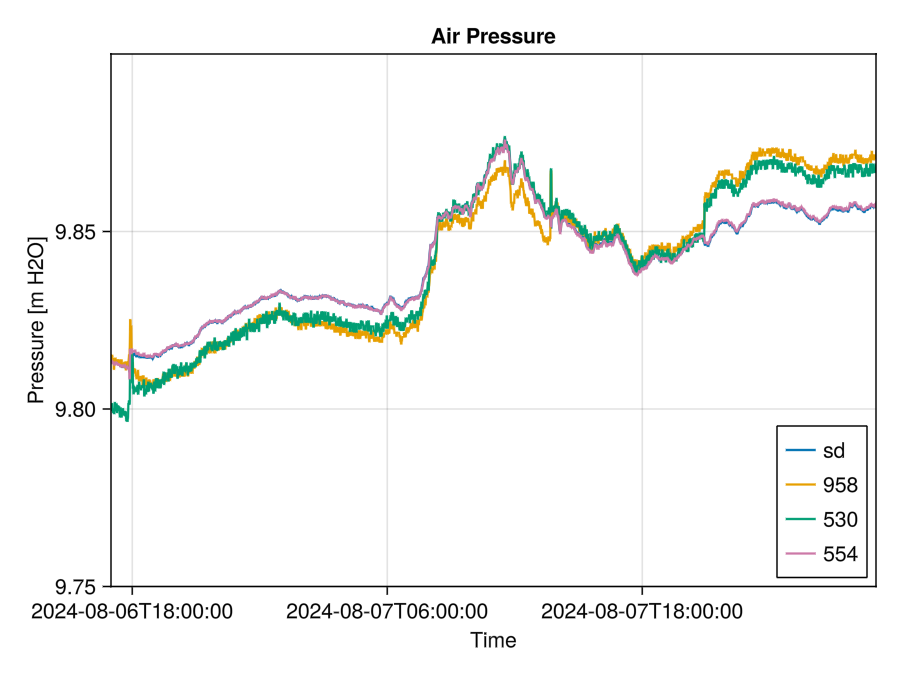

In [11]:
#check calibration of pressure sensors by comparing the values when all sensors measured the air pressure
# looks pretty good
using Dates
fig = Figure()
ax = Axis(fig[1,1], title = "Air Pressure", xlabel = "Time", ylabel = "Pressure [m H2O]")
lines!(ax, d_sd[:t], d_sd[:press], label = "sd")
lines!(ax, d_958_calib[:t], d_958_calib[:press], label = "958")
lines!(ax, d_530_calib[:t], d_530_calib[:press], label = "530")
lines!(ax, d_554_calib[:t], d_554_calib[:press], label = "554")

xmin = DateTime(2024, 8, 6, 17, 00, 0)
xmax = DateTime(2024, 8, 8, 5, 00, 0)
xlims!(ax, xmin, xmax)
ylims!(ax, 9.75, 9.9)

axislegend(ax, position = :rb)
fig

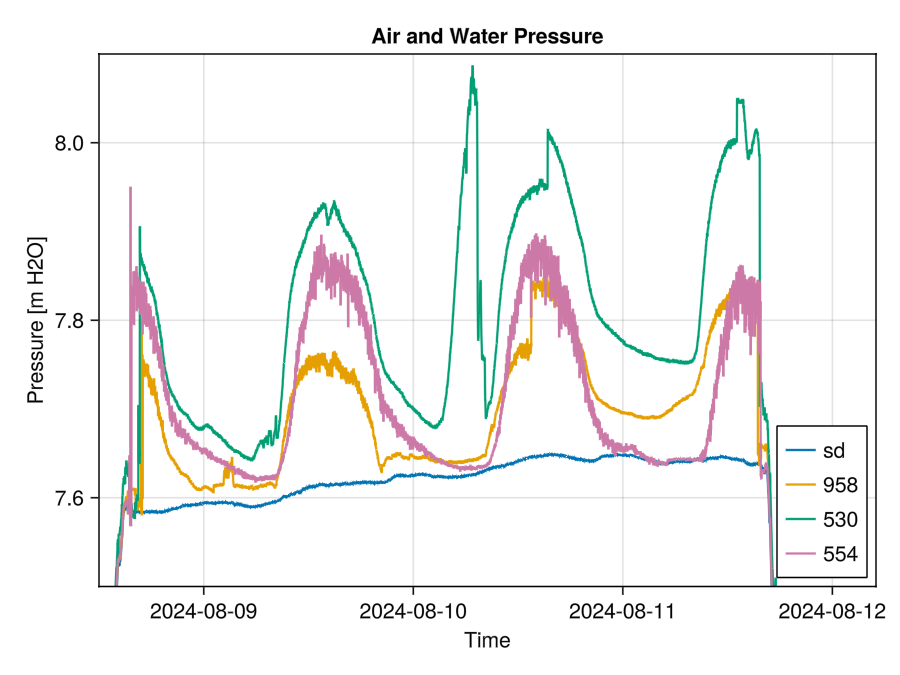

In [12]:
#look at air pressure and water pressure

using Dates
fig = Figure()
ax = Axis(fig[1,1], title = "Air and Water Pressure", xlabel = "Time", ylabel = "Pressure [m H2O]")
lines!(ax, d_sd[:t], d_sd[:press], label = "sd")
lines!(ax, d_958_calib[:t], d_958_calib[:press], label = "958")
lines!(ax, d_530_calib[:t], d_530_calib[:press], label = "530")
lines!(ax, d_554_calib[:t], d_554_calib[:press], label = "554")

xmin = DateTime(2024, 8, 8, 12, 00, 0)
xmax = DateTime(2024, 8, 12, 5, 00, 0)
xlims!(ax, xmin, xmax)
ylims!(ax, 7.5, 8.1)

axislegend(ax, position = :rb)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*